# CAB420, DCNNs, Additional Example 2: Convolutions
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will:
* Have a look at the convolution operator, which is the building block of convolutional neural networks

In [1]:
from scipy import signal
from scipy import datasets
import numpy
import matplotlib.pyplot as plt
import cv2

Convolution is a mathematical operation over two functions. The output is a third funtion, which explains how one function modifies the other. It is defined as:

$f * g := \int_{-\infty}^{+\infty}{f(\tau)g(t-\tau)d\tau}$

This all sounds very abstract, so let's look at what this actually does to an image. We'll just use a sample image from scipy for this.

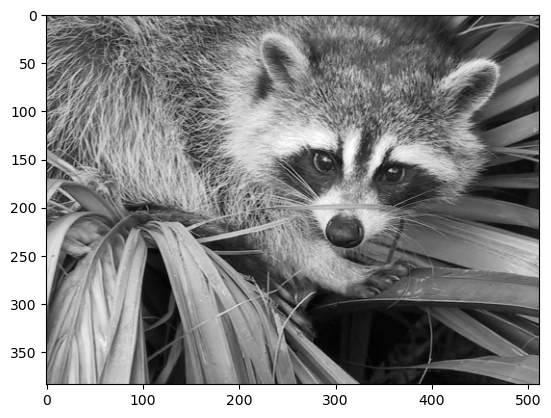

In [2]:
# load image, resize to make the following convolution operations more obvious
image = cv2.resize(datasets.face(gray=True).astype('float') / 255.0, (512, 384))
fig = plt.imshow(image, cmap=plt.get_cmap('gray'));

That image is the first of our functions that we'll use in the convolution. For our second one, we'll use a much smaller image, much like we see with our CNNs. In this case, we'll use the following:

In [3]:
kernel = numpy.array([[-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, -1]])

This is a simple edge detection kernel, which will give stronger responses for pixels that are on an edge. Let's apply that and look at the results.

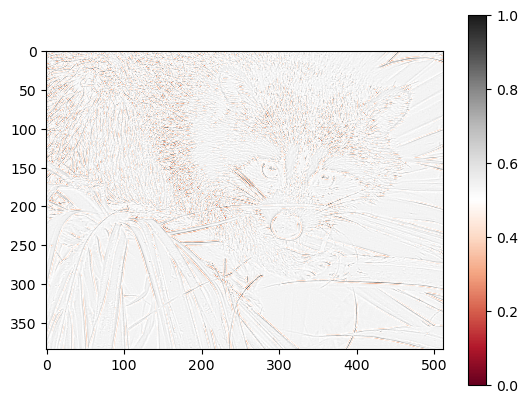

In [4]:
conv_result = signal.convolve2d(image, kernel, boundary='symm', mode='same')
conv_result_norm = (conv_result - conv_result.min()) / (conv_result.max() - conv_result.min())
fig, ax = plt.subplots()
im = ax.imshow(conv_result_norm, cmap=plt.get_cmap('RdGy'));
fig.colorbar(im, ax=ax)

Clearly, we can see we have emphasised the edges, and regions where there are no edges are the middle gray colour. Note that to display this, I've normalised my image.

Let's explore this further. We can think of the convolution at some point being the sum of the product of the two functions. In terms an image and a kernel this means that to compute the result at a given point we:
* crop the region around the point of interest in the image such that it's the same size as the kernel
* perform element wise multiplication of the kernel and the cropped image
* sum the result

If we consider the point at location (1,1) in the image, we can see that this works out.

In [5]:
print(image[0:3, 0:3])
print(kernel)
print(image[0:3, 0:3]*kernel)
print(numpy.sum(image[0:3, 0:3]*kernel))
print(conv_result[1,1])

[[0.42254902 0.53431373 0.56078431]
 [0.32156863 0.44117647 0.47843137]
 [0.44705882 0.49901961 0.57647059]]
[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]
[[-0.42254902 -0.53431373 -0.56078431]
 [-0.32156863  3.52941176 -0.47843137]
 [-0.44705882 -0.49901961 -0.57647059]]
-0.3107843137254904
-0.31078431372549026


What this means is that for our given kernel which has a large positive value at the centre, and negative values elsehwere, we will get a high response for a point where it's surrounds are much darker than it is. Note that the actual implementation of convolution flips the kernel, so for asymmetrical kernels this won't work out, but as our kernel is symmetrical this doesn't matter.

We can also craft kernels that will respond more strongly to certain types of edges. For example we can search for vertical edges:

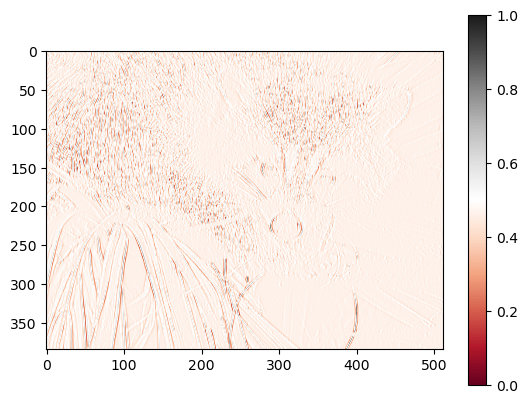

In [6]:
kernel = numpy.array([[-4, 8, -4],
                      [-4, 8, -4],
                      [-4, 8, -4]])
conv_result = signal.convolve2d(image, kernel, boundary='symm', mode='same')
conv_result_norm = (conv_result - conv_result.min()) / (conv_result.max() - conv_result.min())
fig, ax = plt.subplots()
im = ax.imshow(conv_result_norm, cmap=plt.get_cmap('RdGy'));
fig.colorbar(im, ax=ax)

Or horizontal edges

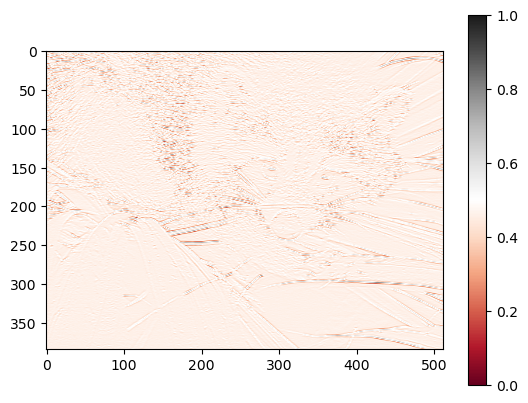

In [7]:
kernel = numpy.array([[-4, -4, -4],
                      [8,   8,  8],
                      [-4, -4, -4]])
conv_result = signal.convolve2d(image, kernel, boundary='symm', mode='same')
conv_result_norm = (conv_result - conv_result.min()) / (conv_result.max() - conv_result.min())
fig, ax = plt.subplots()
im = ax.imshow(conv_result_norm, cmap=plt.get_cmap('RdGy'));
fig.colorbar(im, ax=ax)

CNNs get their power from stacking convolution operations. This means, for example, that:
* the first set of convolutions does something like we've just done, looking for edges or similar
* the second set looks for combinations of those edges, allowing it to identify particular shapes
* the third builds on the second, and can now look for combinations of simple shapes to find more complex shapes
* and so on

Let's explore this in a simplified setting using a blurring kernel.

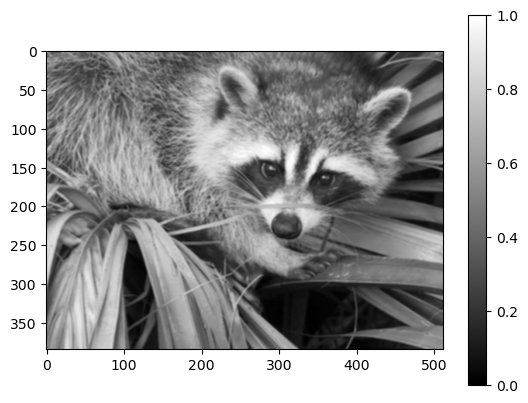

In [8]:
kernel = numpy.array([[0.111, 0.111, 0.111],
                      [0.111, 0.111, 0.111],
                      [0.111, 0.111, 0.111]])
conv_result = signal.convolve2d(image, kernel, boundary='symm', mode='same')
conv_result_norm = (conv_result - conv_result.min()) / (conv_result.max() - conv_result.min())
fig, ax = plt.subplots()
im = ax.imshow(conv_result_norm, cmap=plt.get_cmap('gray'));
fig.colorbar(im, ax=ax)

After one pass, we have a slightly blurred image.

If we stack a bunch more operations on top of this, we get a progressivley more blurred image.

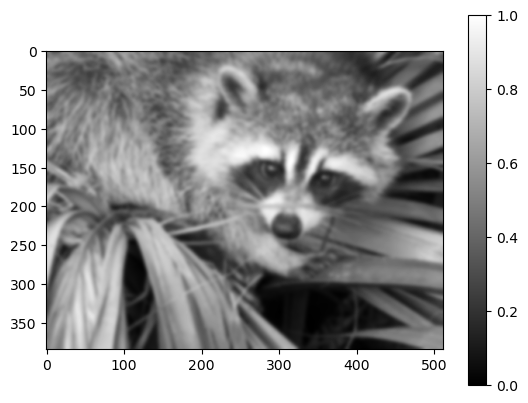

In [9]:
conv_result = signal.convolve2d(conv_result, kernel, boundary='symm', mode='same')
conv_result = signal.convolve2d(conv_result, kernel, boundary='symm', mode='same')
conv_result = signal.convolve2d(conv_result, kernel, boundary='symm', mode='same')
conv_result = signal.convolve2d(conv_result, kernel, boundary='symm', mode='same')
conv_result = signal.convolve2d(conv_result, kernel, boundary='symm', mode='same')
conv_result = signal.convolve2d(conv_result, kernel, boundary='symm', mode='same')
conv_result_norm = (conv_result - conv_result.min()) / (conv_result.max() - conv_result.min())
fig, ax = plt.subplots()
im = ax.imshow(conv_result_norm, cmap=plt.get_cmap('gray'));
fig.colorbar(im, ax=ax)

In a CNN however, we end up with multi-channel images, and multi-channel convolution kernels. Consider a CNN with a first layer with 8 filters. Let's assume our input is a greyscale image like we've been using. Then our output is 8 images, each of which is the image convolved with 1 filter (kernel). This is the input to our next layer.

As our filters have to have the same number of channels as the image, it means that our next set of filters will have 8 channels too. What this means is that those filters are looking for patterns across the channels. This also means that if we have a colour image as our input, our first convolutional layer will learn colour filters, i.e. rather than just look for an edge it might look for a red edge.    